#### Region Convergence Results (2000-2020)

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
## The script here automatically detects the project root by 
# searching upward from the current working directory until 
# it finds a folder containing "data/". 
# ensures that the project remains fully reproducible 
# even when executed from different environments :)

from pathlib import Path

CURRENT_PATH = Path(__file__).resolve() if "__file__" in globals() else Path().resolve()

PROJECT_ROOT = None
for parent in [CURRENT_PATH] + list(CURRENT_PATH.parents):
    if (parent / "data").exists():
        PROJECT_ROOT = parent
        break

if PROJECT_ROOT is None:
    raise FileNotFoundError("Project root not found — expected a directory containing 'data/'.")

print(f"Project root detected as: {PROJECT_ROOT}")

DATA_DIR = PROJECT_ROOT / "data"      
FIG_DIR = PROJECT_ROOT / "figures"     
SCRIPT_DIR = PROJECT_ROOT / "scripts"  

FIG_DIR.mkdir(exist_ok=True) ##create if not exists



Project root detected as: /Users/anniee_me/qtm350-final-project


In [16]:
import os
os.getcwd()

'/Users/anniee_me/qtm350-final-project/scripts'

In [17]:
df = pd.read_csv(DATA_DIR / "wdi_edu_filtered.csv")

In [18]:
plt.style.use("ggplot")  
plt.rcParams['figure.figsize'] = (10, 6)

In [19]:
df = df[~df['series'].str.contains('_')]

regions = [
    'East Asia & Pacific',
    'Latin America & Caribbean',
    'Middle East, North Africa, Afghanistan & Pakistan',
    'South Asia',
    'Sub-Saharan Africa'
]

edu_levels = ['primary', 'secondary', 'tertiary']

year_cols = [c for c in df.columns if "YR" in c]

df_long = df.melt(
    id_vars=['Country', 'series'],
    value_vars=year_cols,
    var_name='year',
    value_name='enrollment'
)

df_long['year'] = df_long['year'].str.replace('YR', '').astype(int)
df_long = df_long[(df_long['year'] >= 2000) & (df_long['year'] <= 2020)]

world = df_long[df_long['Country'] == "World"]

def compute_convergence(level):
    """
    Compute convergence for a given education level.
    Convergence is measured as reduction in the absolute gap to the world average:
        Convergence_Score = |gap2000| - |gap2020|
    Positive score = closer to world average (converging)
    Negative score = further from world average (diverging)
    """
    result = []

    for region in regions:
        region_df = df_long[(df_long['Country'] == region) & (df_long['series'] == level)]
        world_df = world[world['series'] == level]

        r2000 = region_df.loc[region_df['year'] == 2000, 'enrollment'].values[0]
        r2020 = region_df.loc[region_df['year'] == 2020, 'enrollment'].values[0]

        w2000 = world_df.loc[world_df['year'] == 2000, 'enrollment'].values[0]
        w2020 = world_df.loc[world_df['year'] == 2020, 'enrollment'].values[0]

        gap2000 = r2000 - w2000
        gap2020 = r2020 - w2020

        convergence_score = abs(gap2000) - abs(gap2020)

        result.append([
            region,
            level,
            gap2000,
            gap2020,
            convergence_score
        ])

    return pd.DataFrame(result, columns=[
        'Region', 'Level', 'Gap_2000', 'Gap_2020', 'Convergence_Score'
    ])

df_results = pd.concat([compute_convergence(l) for l in edu_levels])

df_results_sorted = df_results.sort_values(
    ["Level", "Convergence_Score"], ascending=False
)

df_results_sorted


,Region,Level,Gap_2000,Gap_2020,Convergence_Score
3,South Asia,tertiary,-10.262691,-11.487999,-1.225308
2,"Middle East, North Africa, Afghanistan & Pakistan",tertiary,-5.927641,-11.402220,-5.474579
0,East Asia & Pacific,tertiary,-2.927410,12.944469,-10.017059
1,Latin America & Caribbean,tertiary,4.333410,15.161251,-10.827841
4,Sub-Saharan Africa,tertiary,-15.099781,-30.509499,-15.409718
3,South Asia,secondary,-11.963470,0.501328,11.462143
4,Sub-Saharan Africa,secondary,-34.036251,-31.802059,2.234192
1,Latin America & Caribbean,secondary,19.908268,20.610397,-0.702129
2,"Middle East, North Africa, Afghanistan & Pakistan",secondary,-9.257473,-15.780060,-6.522587
0,East Asia & Pacific,secondary,2.671848,13.392220,-10.720371


### Enrollment Convergence Line Plots

In [20]:
region_colors = {
    'East Asia & Pacific': 'blue',
    'Latin America & Caribbean': 'orange',
    'Middle East, North Africa, Afghanistan & Pakistan': 'green',
    'South Asia': 'red',
    'Sub-Saharan Africa': 'purple',
    'World Avg': 'black'
}

world_ts = world[['year', 'series', 'enrollment']]
region_ts = df_long[df_long['Country'].isin(regions)]


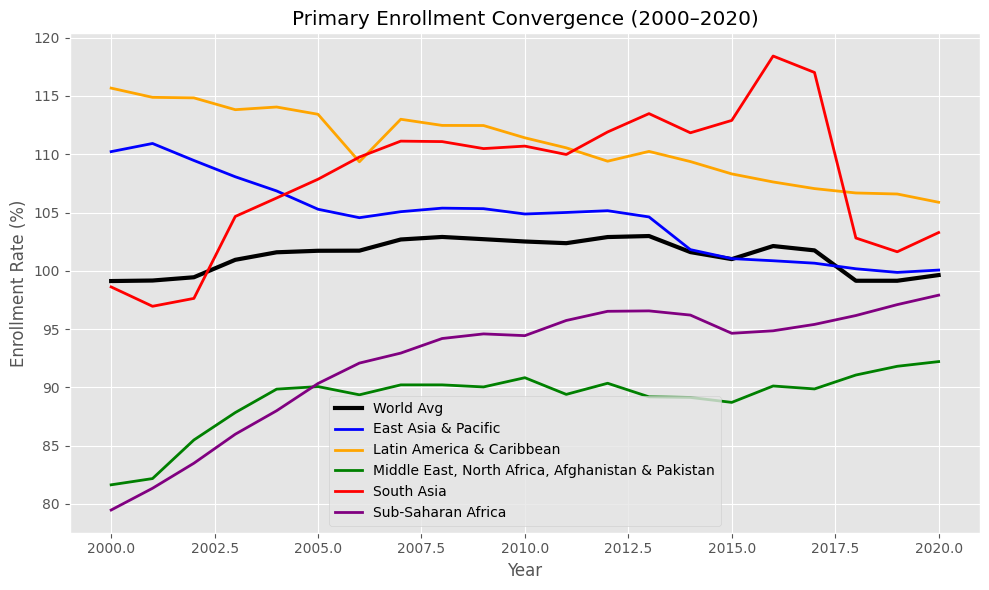

In [21]:
## Plotting convergence for primary education
level = "primary"

plt.figure()

w = world_ts[world_ts['series'] == level]
plt.plot(
    w['year'], w['enrollment'],
    label='World Avg',
    linewidth=3,
    color=region_colors['World Avg']
)

for reg in regions:
    r = region_ts[(region_ts['Country'] == reg) & (region_ts['series'] == level)]
    plt.plot(
        r['year'], r['enrollment'],
        label=reg,
        color=region_colors[reg],
        linewidth=2
    )

plt.title(f"{level.capitalize()} Enrollment Convergence (2000–2020)")
plt.xlabel("Year")
plt.ylabel("Enrollment Rate (%)")
plt.legend()
plt.tight_layout()

plt.savefig(FIG_DIR / f"enrollment_convergence_{level}.png",
            dpi=300, bbox_inches="tight")


plt.show()
plt.close()


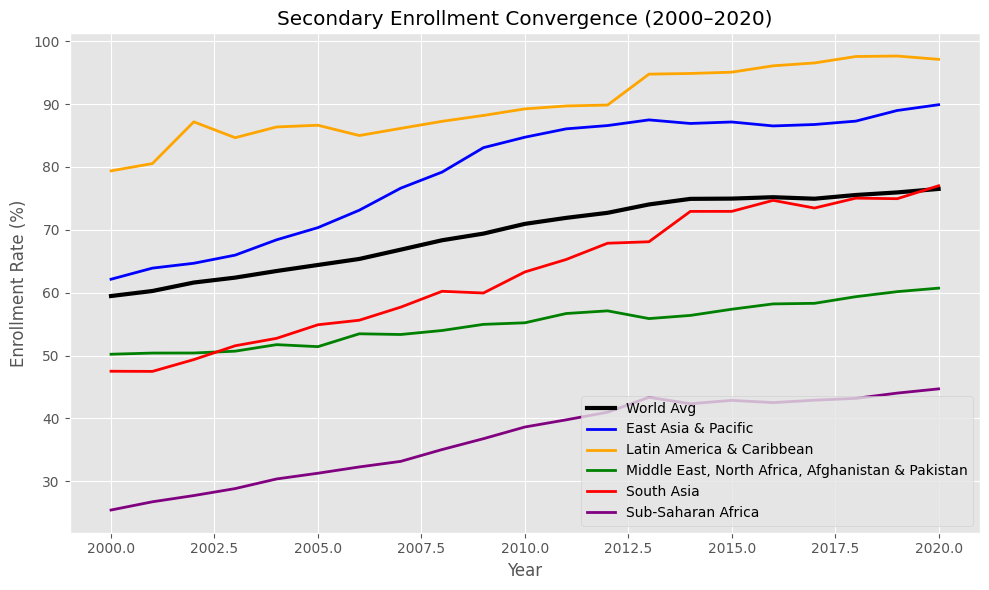

In [22]:
level = "secondary"

plt.figure()

w = world_ts[world_ts['series'] == level]
plt.plot(
    w['year'], w['enrollment'],
    label='World Avg',
    linewidth=3,
    color=region_colors['World Avg']
)

for reg in regions:
    r = region_ts[(region_ts['Country'] == reg) & (region_ts['series'] == level)]
    plt.plot(
        r['year'], r['enrollment'],
        label=reg,
        color=region_colors[reg],
        linewidth=2
    )

plt.title(f"{level.capitalize()} Enrollment Convergence (2000–2020)")
plt.xlabel("Year")
plt.ylabel("Enrollment Rate (%)")
plt.legend()
plt.tight_layout()

plt.savefig(FIG_DIR / f"enrollment_convergence_{level}.png",
            dpi=300, bbox_inches="tight")


plt.show()
plt.close()


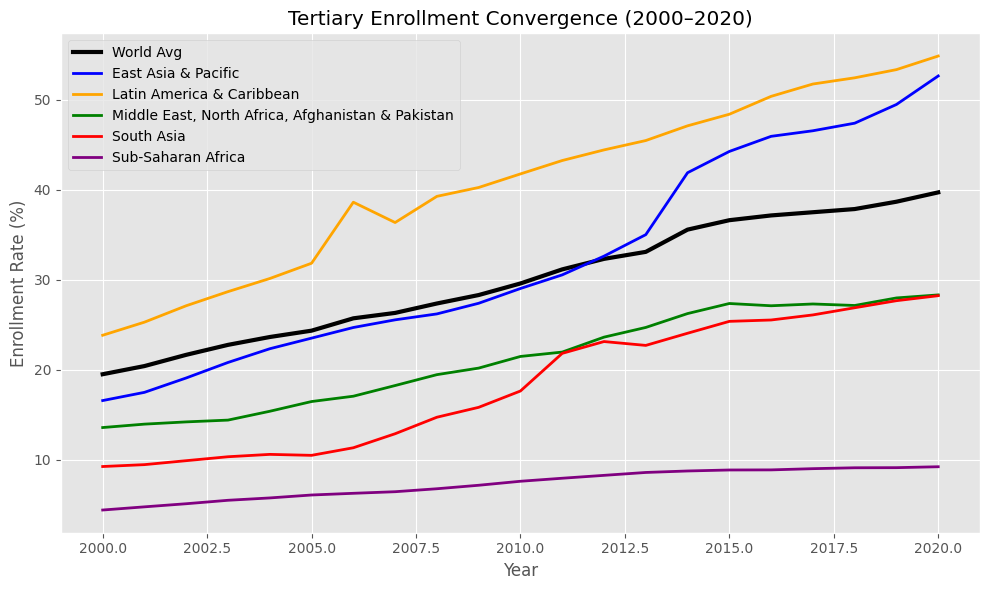

In [23]:
level = "tertiary"

plt.figure()

w = world_ts[world_ts['series'] == level]
plt.plot(
    w['year'], w['enrollment'],
    label='World Avg',
    linewidth=3,
    color=region_colors['World Avg']
)

for reg in regions:
    r = region_ts[(region_ts['Country'] == reg) & (region_ts['series'] == level)]
    plt.plot(
        r['year'], r['enrollment'],
        label=reg,
        color=region_colors[reg],
        linewidth=2
    )

plt.title(f"{level.capitalize()} Enrollment Convergence (2000–2020)")
plt.xlabel("Year")
plt.ylabel("Enrollment Rate (%)")
plt.legend()
plt.tight_layout()

plt.savefig(FIG_DIR / f"enrollment_convergence_{level}.png",
            dpi=300, bbox_inches="tight")


plt.show()
plt.close()


#### Enrollment Convergence Bar Plots

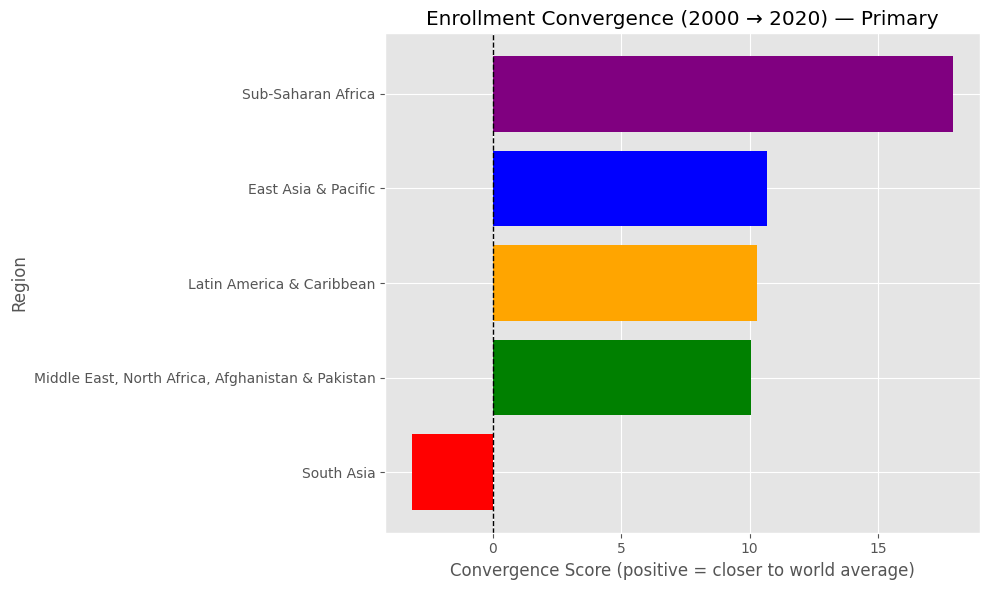

In [24]:
level = "primary"

plt.figure()

subset = df_results_sorted[df_results_sorted['Level'] == level]
subset = subset.sort_values('Convergence_Score', ascending=True)

y_pos = np.arange(len(subset))

bar_colors = [region_colors[reg] for reg in subset['Region']]

plt.barh(
    y_pos,
    subset['Convergence_Score'],
    color=bar_colors
)

plt.yticks(y_pos, subset['Region'])

plt.title(f"Enrollment Convergence (2000 → 2020) — {level.capitalize()}")
plt.xlabel("Convergence Score (positive = closer to world average)")
plt.ylabel("Region")

plt.axvline(0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()

plt.savefig(FIG_DIR / f"enrollment_convergence_bar_{level}.png",
            dpi=300, bbox_inches="tight")


plt.show()
plt.close()


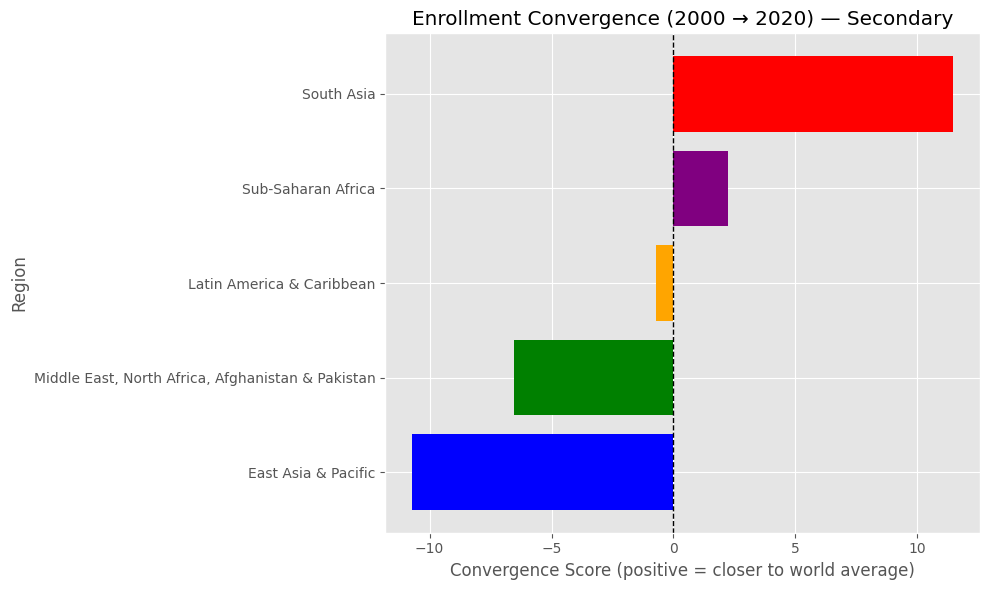

In [25]:
level = "secondary"

plt.figure()

subset = df_results_sorted[df_results_sorted['Level'] == level]
subset = subset.sort_values('Convergence_Score', ascending=True)

y_pos = np.arange(len(subset))

bar_colors = [region_colors[reg] for reg in subset['Region']]

plt.barh(
    y_pos,
    subset['Convergence_Score'],
    color=bar_colors
)

plt.yticks(y_pos, subset['Region'])

plt.title(f"Enrollment Convergence (2000 → 2020) — {level.capitalize()}")
plt.xlabel("Convergence Score (positive = closer to world average)")
plt.ylabel("Region")

plt.axvline(0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()

plt.savefig(FIG_DIR / f"enrollment_convergence_bar_{level}.png",
            dpi=300, bbox_inches="tight")


plt.show()
plt.close()


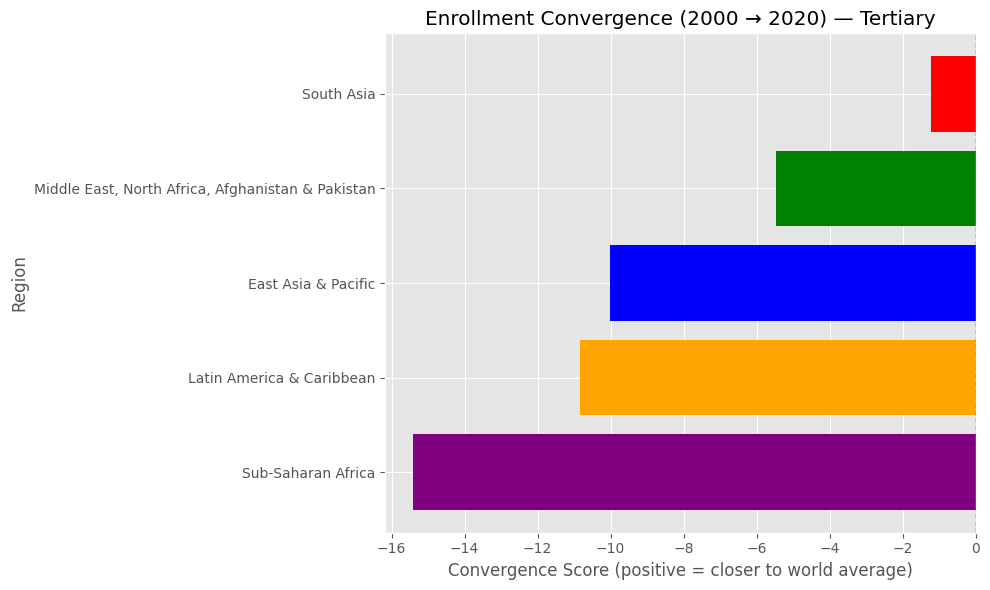

In [26]:
level = "tertiary"

plt.figure()

subset = df_results_sorted[df_results_sorted['Level'] == level]
subset = subset.sort_values('Convergence_Score', ascending=True)

y_pos = np.arange(len(subset))

bar_colors = [region_colors[reg] for reg in subset['Region']]

plt.barh(
    y_pos,
    subset['Convergence_Score'],
    color=bar_colors
)

plt.yticks(y_pos, subset['Region'])

plt.title(f"Enrollment Convergence (2000 → 2020) — {level.capitalize()}")
plt.xlabel("Convergence Score (positive = closer to world average)")
plt.ylabel("Region")

plt.axvline(0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()

plt.savefig(FIG_DIR / f"enrollment_convergence_bar_{level}.png",
            dpi=300, bbox_inches="tight")


plt.show()
plt.close()
